# Data Analysis
## Emotion Lines
Emotion Lines dataset data exploration to retrieve sentiment lexicon and dataset creation. 

In [1]:
import data_analysis as data_analysis

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [2]:
data_location = "../data/EmotionLines-Push/Friends/friends.json"
data_location_full = "/Users/isabeldias/Documents/GitHub/thesis/data/EmotionLines-Push/Friends/friends.json"

In [4]:
data_dict = data_analysis.load_json(data_location)

In [5]:
df, emotions = data_analysis.dict2dataframe_emotion_lines_push(data_dict)

df.head()

conversation: 100%|██████████| 1000/1000 [00:55<00:00, 18.08it/s]


,conv_id,speaker,utterance,emotion,annotation
0,0,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",non-neutral,0002120
1,0,Monica,What?,surprise,1000130
2,0,Ross,"Or! Or, we could go to the bank, close our acc...",neutral,3000200
3,0,Chandler,Youre a genius!,joy,0500000
4,0,Joey,"Aww, man, now we wont be bank buddies!",sadness,0040100


### Emotions in the corpus

In [6]:
emotions

['non-neutral',
 'surprise',
 'neutral',
 'joy',
 'sadness',
 'anger',
 'disgust',
 'fear']

### Dictionary with sentences per emotion

In [7]:
emotions_corpus_dict = {}

for emotion in emotions:
    emotions_corpus_dict[emotion] = []
    
    # only select portion of the corpus correspondent to the specified emotion
    emotion_df = df[df['emotion'] == emotion]
    emotion_corpus = emotion_df['utterance'].values
    
    for utterance in emotion_corpus:
        emotions_corpus_dict[emotion].append(utterance.strip())
        
emotions_corpus_dict['neutral'][:5]

['Or! Or, we could go to the bank, close our accounts and cut them off at the source.',
 'Now, there\x92s two reasons.',
 'Hey.',
 'Ohh, you guys, remember that cute client I told you about? I bit him.',
 'On the touchy.']

### Balancing

In [8]:
for emotion in emotions_corpus_dict:
    print(len(emotions_corpus_dict[emotion]))

2772
1657
6530
1710
498
759
331
246


Text(0, 0.5, 'Number of sentences')

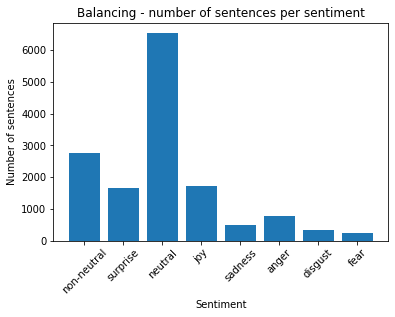

In [9]:
plt.bar(emotions, [len(emotions_corpus_dict[emotion]) for emotion in emotions_corpus_dict])
plt.xticks(rotation=45)
plt.title("Balancing - number of sentences per sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of sentences")

### Simple Term Frequency

In [10]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,3), stop_words='english')

vocabulary_tf_sorted = {}

for emotion in tqdm(emotions, desc="emotion"):
    # returns document x term matrix
    X = vectorizer.fit_transform(emotions_corpus_dict[emotion])
    
    tf_corpus = []
    
    term_doc_matrix = X.T
    
    for term_count in term_doc_matrix:
        tf_corpus.append(np.sum(term_count))
        
    vocabulary_tf = zip(vectorizer.get_feature_names(), tf_corpus)
    
    vocabulary_tf_reduced = [(word, tf) for (word, tf) in vocabulary_tf if tf > 2]
    
    vocabulary_tf_sorted[emotion] = sorted(vocabulary_tf_reduced, key = lambda x: x[1], reverse=True)

emotion: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


In [11]:
for emotion in vocabulary_tf_sorted:
    print(emotion)
    print(vocabulary_tf_sorted[emotion][:10])
    print("---------------------------")

non-neutral
[('oh', 354), ('know', 259), ('just', 237), ('don', 228), ('okay', 162), ('yeah', 156), ('hey', 155), ('right', 145), ('like', 141), ('think', 121)]
---------------------------
surprise
[('oh', 366), ('god', 156), ('oh god', 138), ('really', 127), ('whoa', 80), ('wow', 77), ('hey', 72), ('did', 70), ('know', 70), ('just', 50)]
---------------------------
neutral
[('know', 624), ('okay', 624), ('yeah', 584), ('oh', 488), ('just', 446), ('right', 361), ('hey', 334), ('don', 312), ('uh', 297), ('ll', 230)]
---------------------------
joy
[('oh', 246), ('hey', 198), ('great', 141), ('yeah', 139), ('know', 98), ('okay', 96), ('good', 84), ('hi', 83), ('love', 81), ('thank', 80)]
---------------------------
sadness
[('sorry', 115), ('know', 66), ('just', 61), ('oh', 50), ('gonna', 41), ('don', 37), ('mean', 30), ('really', 27), ('yeah', 26), ('think', 25)]
---------------------------
anger
[('don', 83), ('know', 64), ('oh', 48), ('just', 46), ('okay', 46), ('gonna', 33), ('right'

### TF-IDF

**Idea**: The sentences of a single sentiment will belong to a unique document. We will rank each token of the document when compared to the full corpus.

**Note**: Each document will be a string with all sentences belonging to a single sentiment.

In [12]:
corpus_by_emotion = []

for emotion in tqdm(emotions, desc="emotion"): 
    corpus = ""
    
    # select examples of the corpus that are labelled with the specific sentiment 
    emotion_df = df[df['emotion'] == emotion]
    emotion_corpus = emotion_df['utterance'].values
    
    # preprocessing + building string corpus
    for sentence in tqdm(emotion_corpus, desc="sentence"):
        corpus += data_analysis.preprocessing(sentence, lower=True, punct=True) + " "
        
    corpus_by_emotion.append(corpus)

sentence: 100%|██████████| 2772/2772 [00:00<00:00, 303947.79it/s]

sentence: 100%|██████████| 1657/1657 [00:00<00:00, 325662.42it/s]

sentence: 100%|██████████| 6530/6530 [00:00<00:00, 260803.54it/s]

sentence: 100%|██████████| 1710/1710 [00:00<00:00, 231363.22it/s]

sentence: 100%|██████████| 498/498 [00:00<00:00, 166554.77it/s]

sentence: 100%|██████████| 759/759 [00:00<00:00, 207758.06it/s]

sentence: 100%|██████████| 331/331 [00:00<00:00, 207149.30it/s]

emotion: 100%|██████████| 8/8 [00:00<00:00, 78.53it/s]


In [13]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), analyzer="word", sublinear_tf=True)

tfidf_vectorspace = tfidf_vectorizer.fit_transform(corpus_by_emotion)

In [14]:
# matrix: emotion x tokens
tfidf_vectorspace.shape

(8, 146611)

From this vectorspace we want to find the top n most relevant tokens per sentiment, i.e., sort each line in the vectorspace and retrieve the top n.

In [15]:
emotions_lexicon = {}

n = 10

feature_array = np.array(tfidf_vectorizer.get_feature_names())

for i, tfidf_scores in tqdm(enumerate(tfidf_vectorspace)):
    tfidf_sorting = np.argsort(tfidf_scores.toarray()).flatten()[::-1]
    top_n = feature_array[tfidf_sorting][:n]
    
    emotions_lexicon[emotions[i]] = top_n

8it [00:00, 68.48it/s]


In [16]:
emotions_lexicon

{'non-neutral': array(['you', 'not yet not', 'yet not', 'yet not yet', 'the', 'it', 'ow',
        'to', 'that', 'and'], dtype='<U35'),
 'surprise': array(['you serious', 'whoa whoa whoa', 'whoa whoa', 'are you serious',
        'really what', 'what what', 'whoa what', 'ow', 'really oh', 'you'],
       dtype='<U35'),
 'neutral': array(['you', 'the', 'assistant', 'to', 'it', 'that', 'yeah listen', 'la',
        'hello', 'okay yeah'], dtype='<U35'),
 'joy': array(['yay', 'dum dum', 'dum dum dum', 'you', 'dum', 'kiss me',
        'morning here', 'and hey', 'so sweet', 'hoo'], dtype='<U35'),
 'sadness': array(['sorry well', 'you', 'gonna miss you', 'and broke', 'miss you',
        'sorry no', 'to', 'and', 'sorry', 'it'], dtype='<U35'),
 'anger': array(['joey joey joey', 'you', 'to', 'it', 'ow', 'damnit',
        'all your fault', 'horny bitch', 'marry her', 'is all your'],
       dtype='<U35'),
 'disgust': array(['ew', 'ew ew', 'ew ew ew', 'you', 'eww', 'spend the', 'the',
        'that', '